#**Osservazioni sulle vendite mensili di prodotti dei settori Calcio, Pesca e Casual**



In [1]:
#https://github.com/TommasoStrada/Progetto-Data-Science-Lab

The XGBoost (eXtreme Gradient Boosting) is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm that attempts to accurately predict a target variable by combining an ensemble of estimates from a set of simpler and weaker models. The XGBoost algorithm performs well in machine learning competitions because of its robust handling of a variety of data types, relationships, distributions, and the variety of hyperparameters that you can fine-tune. You can use XGBoost for regression, classification (binary and multiclass), and ranking problems.

# **COSE DA SETTARE DOPO AVER COPIATO IL CODICE IN FUNZIONE DELLE DIVERSE GRANULARITA':**
- repo_alessandro_calcio --> nome aggregazione
- uso delle repo del team
- scommentare il cambio di tipo nella data: ds_calcio_annuale['year'] = pd.to_datetime(ds_calcio_annuale['year'])
- cambiare i nome delle variabili temporali in month, trimestre e week
- nomi features, legenda e titolo nei plot
- cosa vogliamo come altre misure di bonta delle predizioni
- sistemare asse y con valore delle vendite più leggibile rispetto alla notazione esponenziale
- Lista di params modificata che cambiamo dopo un primo giro di run per raccogliere i dati su cambiamenti di performance e i plot da inserire nel record per i confronti e le dimostrazioni di cura delle performance

In [2]:
#!pip install xgboost 1.6

In [3]:
import math
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost

In [4]:
shift_mensile = 1        #mese precedente
shift_annuale = 12       #stesso mese, anno precedente
shift_scelto = shift_mensile

In [5]:
repo_alessandro_calcio = "https://github.com/Alessandro-Fasani/DsLab/raw/main/calcio_mensile.csv"
repo_alessandro_pesca = "https://github.com/Alessandro-Fasani/DsLab/raw/main/pesca_mensile.csv"
repo_alessandro_casual = "https://github.com/Alessandro-Fasani/DsLab/raw/main/casual_mensile.csv"

repo_team_calcio = ""
repo_team_pesca = ""
repo_team_casual = ""

In [6]:
ds_calcio = pd.read_csv(repo_alessandro_calcio)
ds_pesca = pd.read_csv(repo_alessandro_pesca)
ds_casual = pd.read_csv(repo_alessandro_casual)

In [7]:
ds_calcio['year'] = pd.to_datetime(ds_calcio['year'])
ds_calcio = ds_calcio[ds_calcio["year"] <= "2021-12-31" ]

ds_pesca['year'] = pd.to_datetime(ds_pesca['year'])
ds_pesca = ds_pesca[ds_pesca["year"] <= "2021-12-31" ]

ds_casual['year'] = pd.to_datetime(ds_casual['year'])
ds_casual = ds_casual[ds_casual["year"] <= "2021-12-31" ]
ds_casual
#ds_casual.dtypes

,Unnamed: 0,year,revenue
0,0,2014-01-31,6863.44
1,1,2014-02-28,141796.91
2,2,2014-03-31,470230.18
3,3,2014-04-30,371651.71
4,4,2014-05-31,315736.45
...,...,...,...
91,91,2021-08-31,146709.43
92,92,2021-09-30,165473.20
93,93,2021-10-31,199773.99
94,94,2021-11-30,249497.74


In [8]:
porzione_test = round(len(ds_calcio) * 0.2)       # 20% circa verra usato per il test 
porzione_test_casual = round(len(ds_casual) * 0.2) 

ds_casual.head(50)

,Unnamed: 0,year,revenue
0,0,2014-01-31,6863.44
1,1,2014-02-28,141796.91
2,2,2014-03-31,470230.18
3,3,2014-04-30,371651.71
4,4,2014-05-31,315736.45
5,5,2014-06-30,198836.44
6,6,2014-07-31,469731.71
7,7,2014-08-31,265417.48
8,8,2014-09-30,398348.58
9,9,2014-10-31,305739.68


In [9]:
print("xgboost versione numero: ", xgboost.__version__)

xgboost versione numero:  0.90


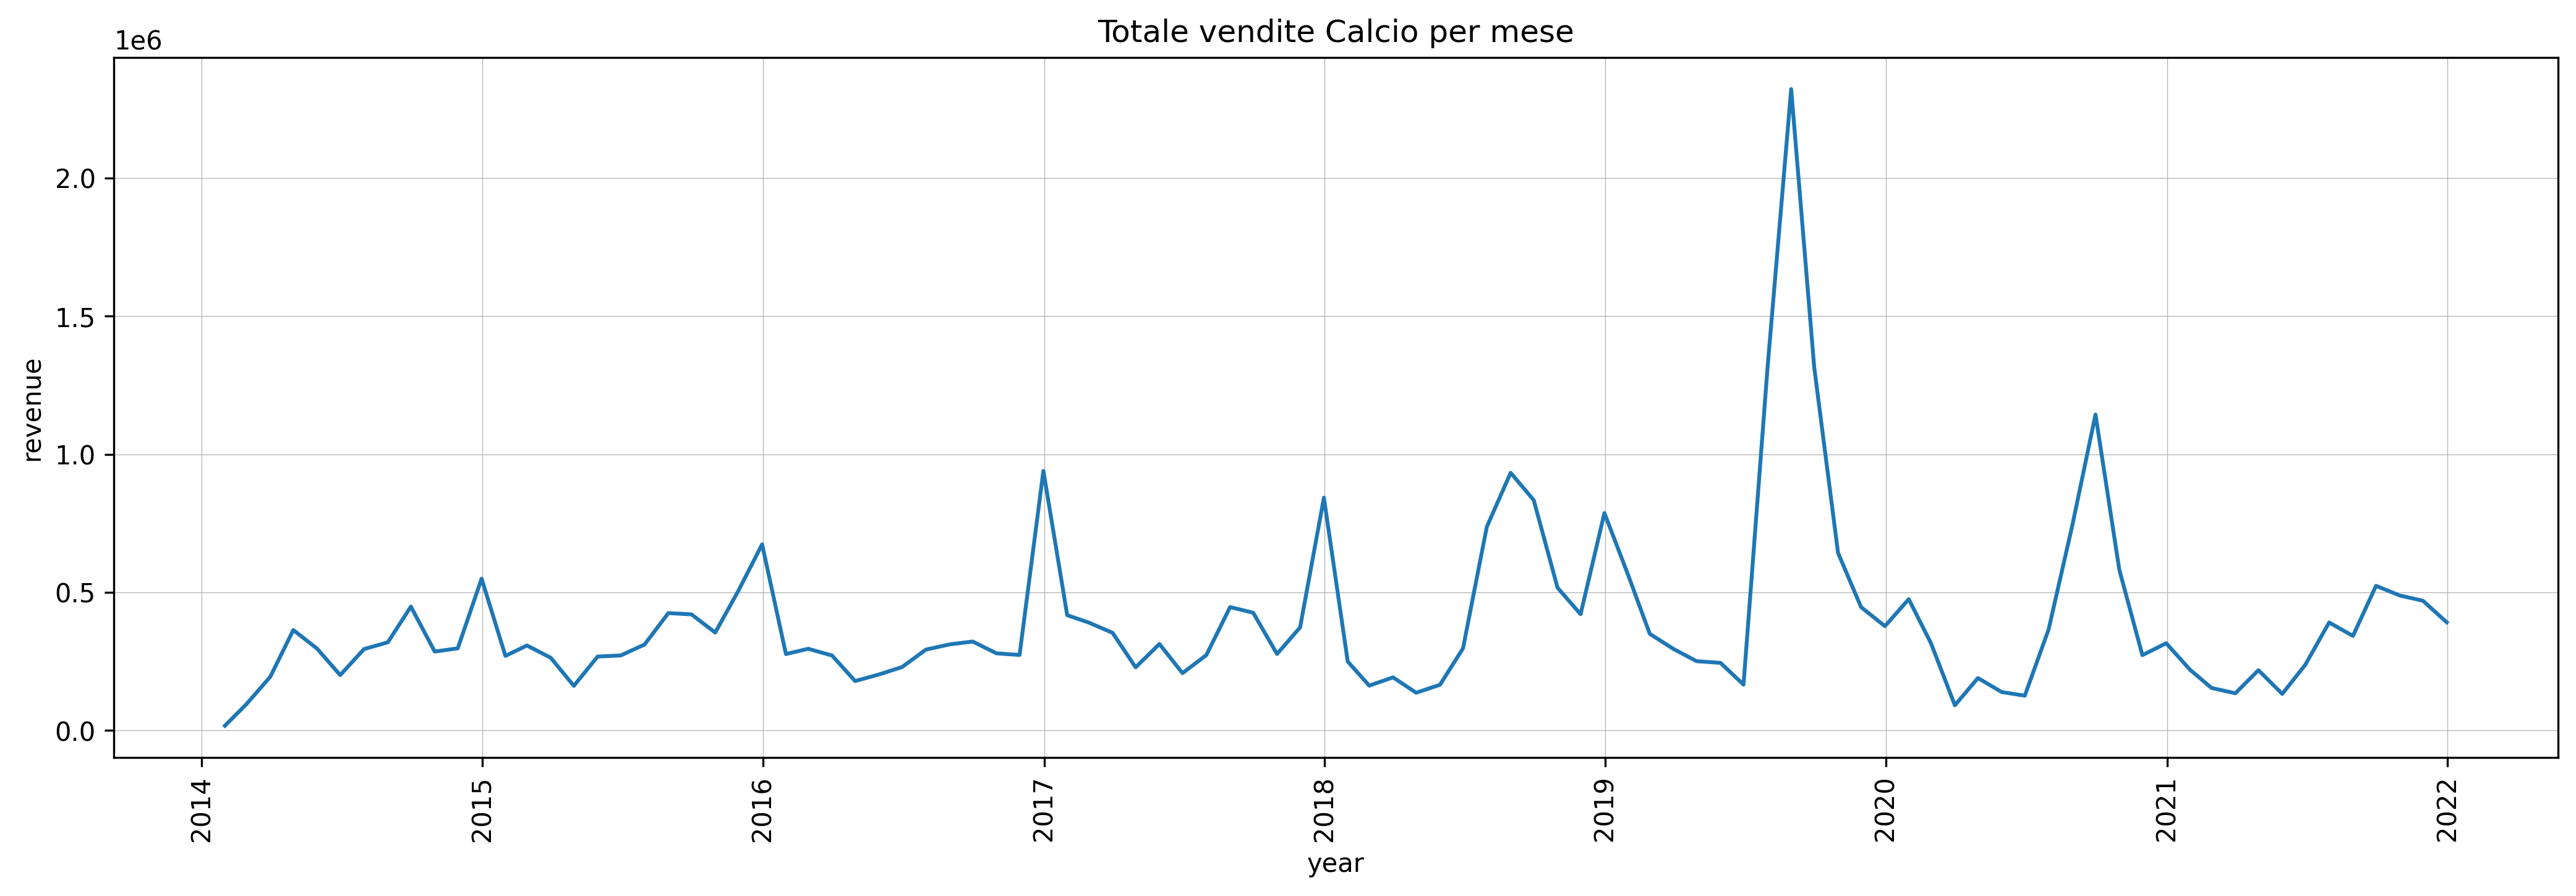

In [10]:
plt.rcParams.update({'figure.figsize': (17, 5), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_calcio, x='year',  y='revenue')
plt.grid(linestyle='-', linewidth=0.3)
plt.title("Totale vendite Calcio per mese")
ax.tick_params(axis='x', rotation=90)

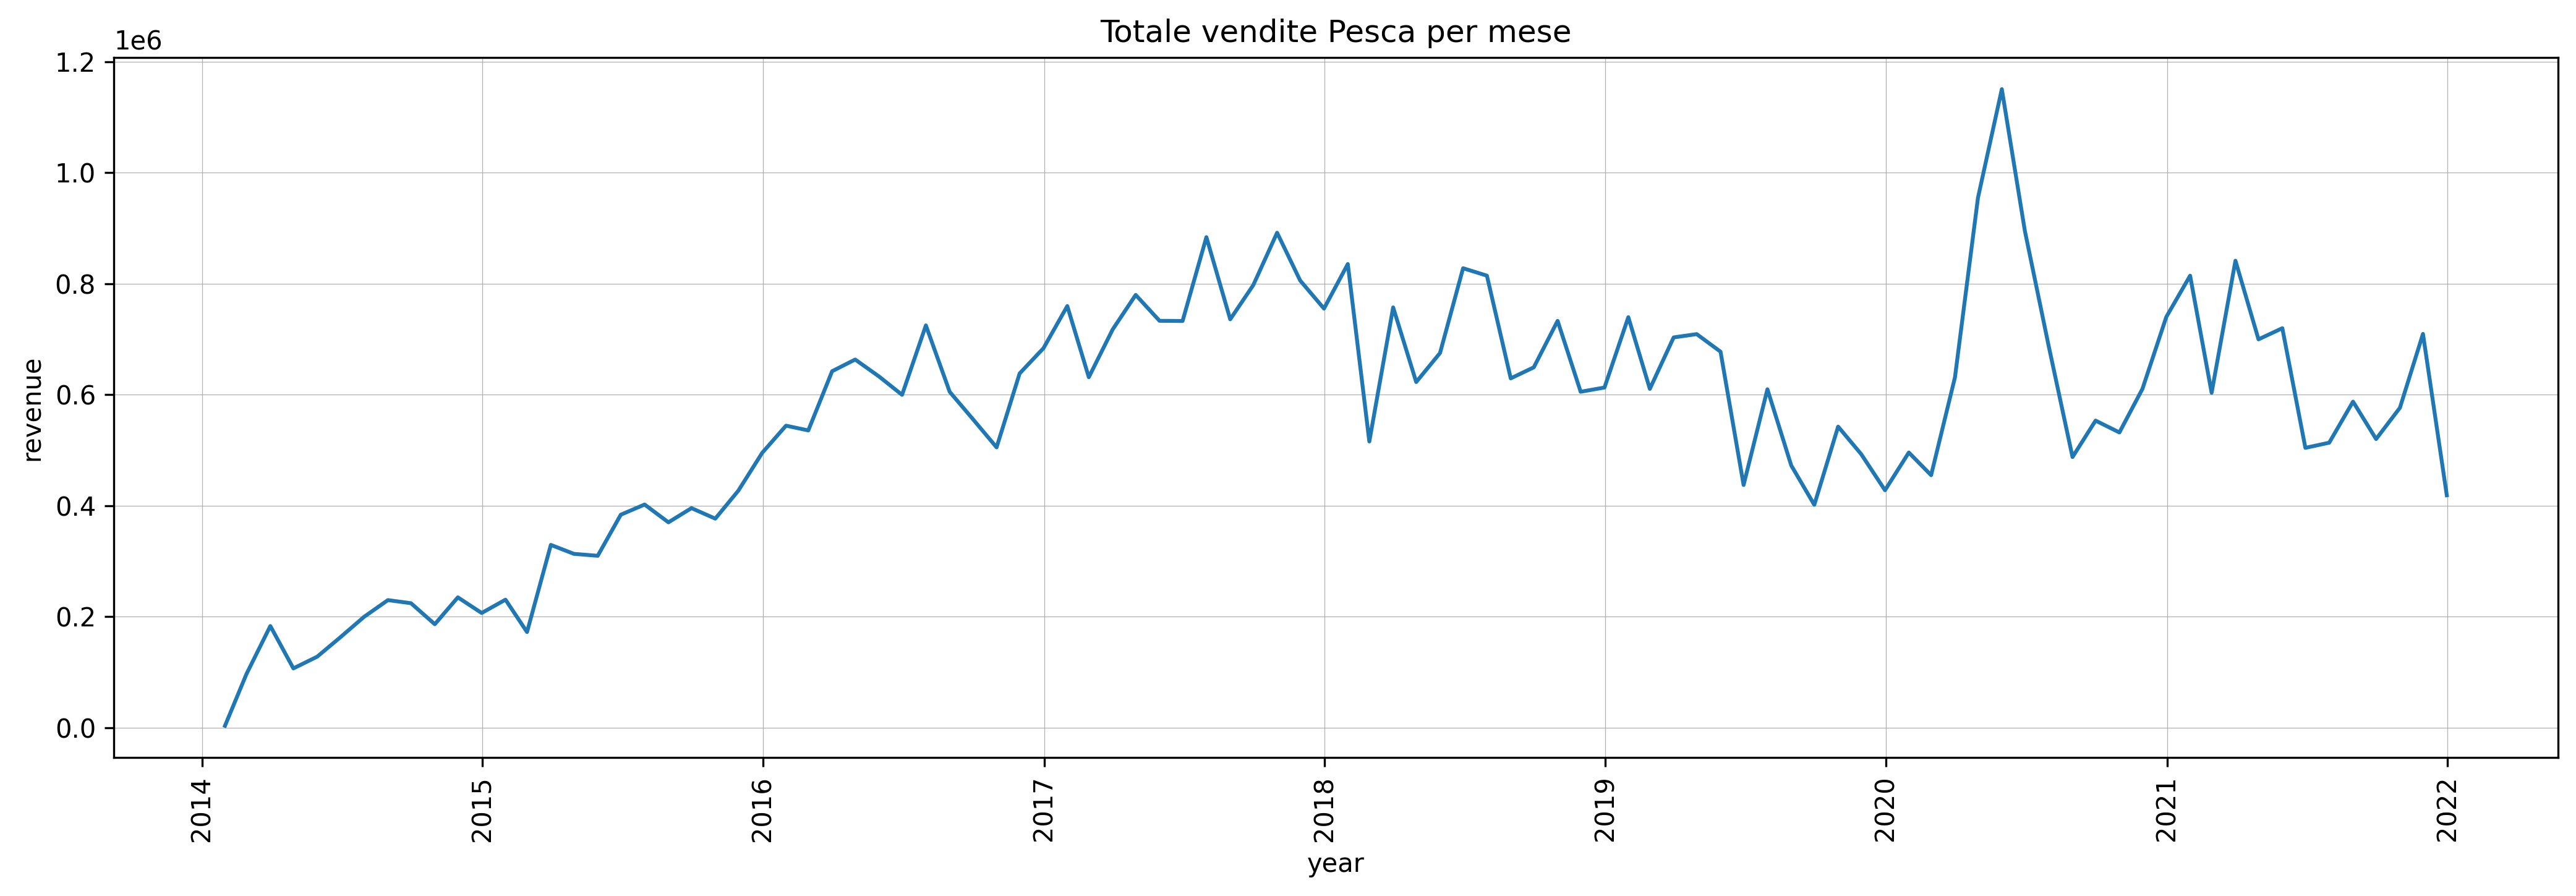

In [11]:
plt.rcParams.update({'figure.figsize': (17, 5), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_pesca, x='year',  y='revenue')
plt.grid(linestyle='-', linewidth=0.3)
plt.title("Totale vendite Pesca per mese")
ax.tick_params(axis='x', rotation=90)

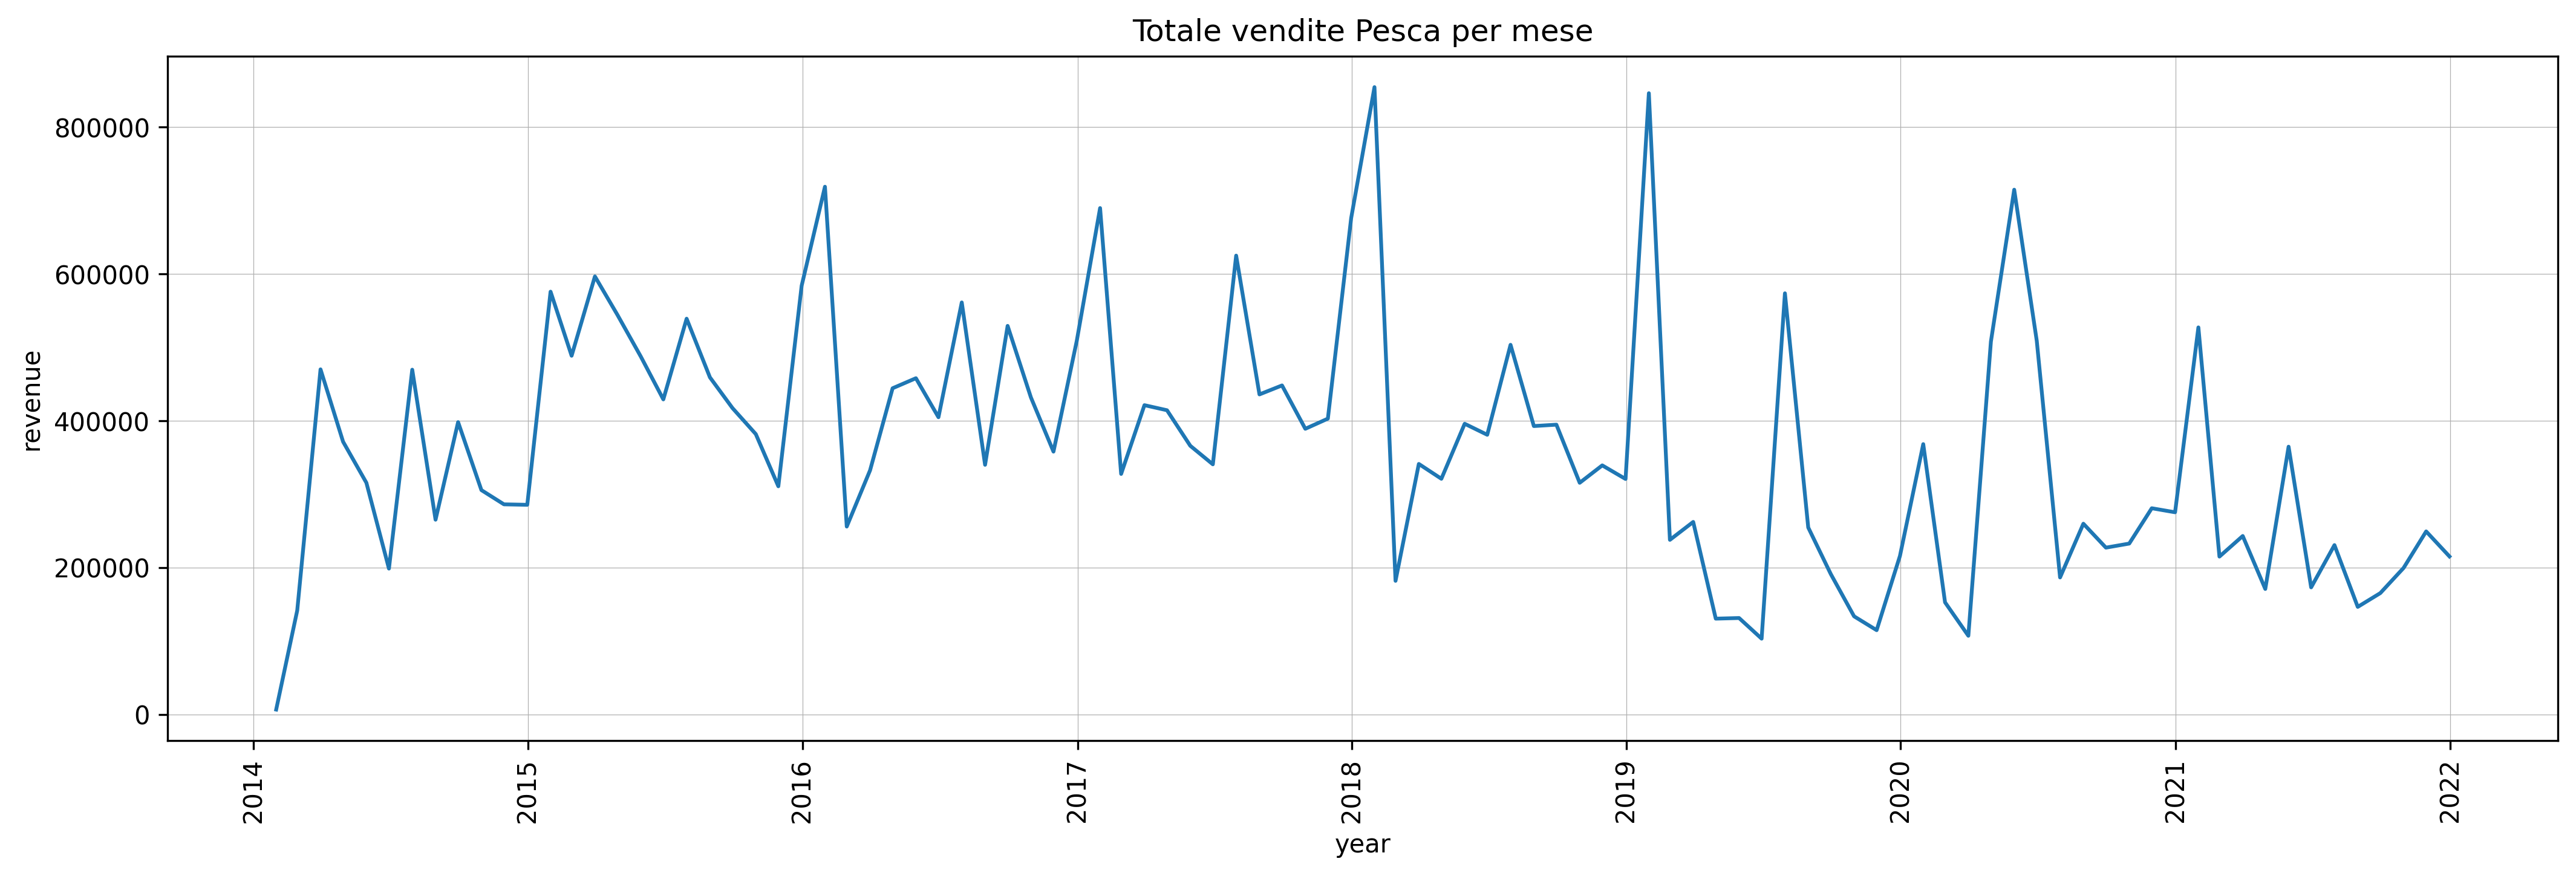

In [12]:
plt.rcParams.update({'figure.figsize': (17, 5), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_casual, x='year',  y='revenue')
plt.title("Totale vendite Pesca per mese")
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [13]:
ds_calcio["totale_periodo_prec"] = ds_calcio["revenue"].shift(+shift_scelto)
ds_pesca["totale_periodo_prec"] = ds_pesca["revenue"].shift(+shift_scelto)
ds_casual["totale_periodo_prec"] = ds_casual["revenue"].shift(+shift_scelto)

ds_casual = ds_casual[["year","totale_periodo_prec","revenue"]]

ds_calcio= ds_calcio.dropna()  
ds_pesca= ds_pesca.dropna()    
ds_casual= ds_casual.dropna()


print(ds_calcio.shape)
print(ds_pesca.shape)
print(ds_casual.shape)

(95, 3)
(95, 3)
(95, 3)


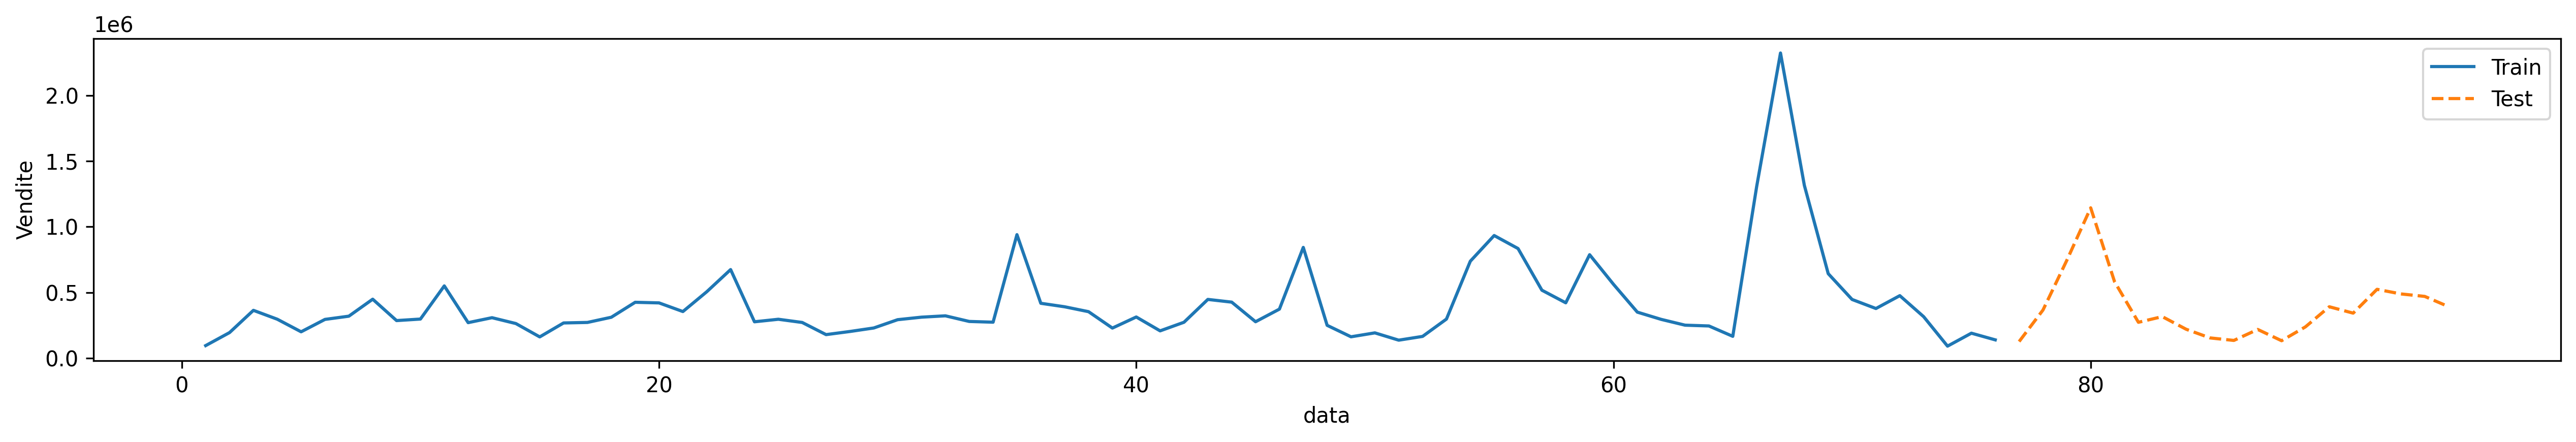

In [14]:
#LIST INPUT, divisione tra parte train e parte dedicata al test
x_calcio = ds_calcio[['totale_periodo_prec']]
x_pesca = ds_pesca[['totale_periodo_prec']]
x_casual = ds_casual[['totale_periodo_prec']]

x_calcio_to_train = x_calcio.iloc[:(len(x_calcio)-porzione_test)]
x_pesca_to_train = x_pesca.iloc[:(len(x_pesca)-porzione_test)]
x_casual_to_train = x_casual.iloc[:(len(x_casual)-porzione_test_casual)]


x_calcio_to_test = x_calcio.iloc[(len(x_calcio)-porzione_test):]
x_pesca_to_test = x_pesca.iloc[(len(x_pesca)-porzione_test):]
x_casual_to_test = x_casual.iloc[(len(x_casual)-porzione_test_casual):]


#LIST OUTPUT, divisione tra parte train e parte dedicata al test
y_calcio = ds_calcio[['revenue']]
y_pesca = ds_pesca[['revenue']]
y_casual = ds_casual[['revenue']]

y_calcio_to_train = y_calcio.iloc[:(len(y_calcio)-porzione_test)]
y_pesca_to_train = y_pesca.iloc[:(len(y_pesca)-porzione_test)]
y_casual_to_train = y_casual.iloc[:(len(y_casual)-porzione_test_casual)]


y_calcio_to_test = y_calcio.iloc[(len(y_calcio)-porzione_test):]
y_pesca_to_test = y_pesca.iloc[(len(y_pesca)-porzione_test):]
y_casual_to_test = y_casual.iloc[(len(y_casual)-porzione_test_casual):]


fig, ax = plt.subplots(figsize=(17, 3))
ax.plot(y_calcio_to_train, ls='-', label='Train')
ax.plot(y_calcio_to_test, ls='--', label='Test')
ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [15]:
estimator_calcio = XGBRegressor(objective='reg:squarederror', n_estimators=160, learning_rate=0.01)
estimator_pesca = XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.01)
estimator_casual = XGBRegressor(objective='reg:squarederror', n_estimators=160, learning_rate=0.01)

estimator_calcio.fit(x_calcio_to_train, y_calcio_to_train,
              eval_set=[(x_calcio_to_train, y_calcio_to_train), (x_calcio_to_test, y_calcio_to_test)],
              eval_metric='mae')

estimator_pesca.fit(x_pesca_to_train, y_pesca_to_train,
              eval_set=[(x_pesca_to_train, y_pesca_to_train), (x_pesca_to_test, y_pesca_to_test)],
              eval_metric='mae')

estimator_casual.fit(x_casual_to_train, y_casual_to_train,
              eval_set=[(x_casual_to_train, y_casual_to_train), (x_casual_to_test, y_casual_to_test)],
              eval_metric='mae')

[0]	validation_0-mae:403271	validation_1-mae:378531
[1]	validation_0-mae:399484	validation_1-mae:375006
[2]	validation_0-mae:395733	validation_1-mae:371514
[3]	validation_0-mae:392031	validation_1-mae:367974
[4]	validation_0-mae:388365	validation_1-mae:364466
[5]	validation_0-mae:384707	validation_1-mae:360818
[6]	validation_0-mae:381110	validation_1-mae:357376
[7]	validation_0-mae:377546	validation_1-mae:353965
[8]	validation_0-mae:374016	validation_1-mae:350585
[9]	validation_0-mae:370494	validation_1-mae:347072
[10]	validation_0-mae:367030	validation_1-mae:343755
[11]	validation_0-mae:363595	validation_1-mae:340461
[12]	validation_0-mae:360172	validation_1-mae:337047
[13]	validation_0-mae:356805	validation_1-mae:333822
[14]	validation_0-mae:353470	validation_1-mae:330627
[15]	validation_0-mae:350163	validation_1-mae:327454
[16]	validation_0-mae:346867	validation_1-mae:324166
[17]	validation_0-mae:343625	validation_1-mae:321059
[18]	validation_0-mae:340411	validation_1-mae:317974
[19

XGBRegressor(learning_rate=0.01, n_estimators=160, objective='reg:squarederror')

In [16]:
predictions_calcio = estimator_calcio.predict(x_calcio_to_test)
predictions_pesca = estimator_pesca.predict(x_pesca_to_test)
predictions_casual = estimator_casual.predict(x_casual_to_test)

#ds_calcio_annuale = ds_calcio_annuale.reset_index().drop('index', axis=1)  #non posso usarli perchè me li aggiunge all'inizio del dataset
#ds_calcio_annuale['predictions'] = pd.Series(predictions)

#plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
#fig, ax = plt.subplots()
#sns.lineplot(data=ds_calcio_annuale, x= "year", y='revenue')
#sns.lineplot(data=ds_calcio_annuale, x='year', y='predictions', palette= "red")
#plt.grid(linestyle='-', linewidth=0.3)
#ax.tick_params(axis='x', rotation=90)

In [17]:
calcio_evalutation_ds = ds_calcio[(len(ds_calcio)-porzione_test):]   
calcio_evalutation_ds = calcio_evalutation_ds.reset_index().drop('index', axis=1)
calcio_evalutation_ds['predictions'] = pd.Series(predictions_calcio)
calcio_evalutation_ds

,year,revenue,totale_periodo_prec,predictions
0,2020-06-30,126425.81,139353.94,1.743312e+05
1,2020-07-31,366231.25,126425.81,1.743312e+05
2,2020-08-31,744662.00,366231.25,3.144873e+05
3,2020-09-30,1143860.62,744662.00,4.137577e+05
4,2020-10-31,581780.80,1143860.62,1.238258e+06
5,2020-11-30,273004.54,581780.80,3.316428e+05
6,2020-12-31,316115.35,273004.54,3.069455e+05
7,2021-01-31,220170.52,316115.35,2.738790e+05
8,2021-02-28,154246.91,220170.52,2.331040e+05
9,2021-03-31,134986.46,154246.91,1.996833e+05


In [18]:
pesca_evalutation_ds = ds_pesca[(len(ds_pesca)-porzione_test):]  
pesca_evalutation_ds = pesca_evalutation_ds.reset_index().drop('index', axis=1)
pesca_evalutation_ds['predictions'] = pd.Series(predictions_pesca)
pesca_evalutation_ds

,year,revenue,totale_periodo_prec,predictions
0,2020-06-30,894853.57,1150386.50,873690.2500
1,2020-07-31,687405.89,894853.57,728292.8750
2,2020-08-31,487386.30,687405.89,670114.0625
3,2020-09-30,553079.33,487386.30,478930.9375
4,2020-10-31,531739.65,553079.33,562488.1875
5,2020-11-30,610337.83,531739.65,573182.8125
6,2020-12-31,739810.32,610337.83,661847.1250
7,2021-01-31,814191.95,739810.32,675275.3750
8,2021-02-28,603193.05,814191.95,680568.8125
9,2021-03-31,841232.01,603193.05,572283.5000


In [19]:
casual_evalutation_ds = ds_casual[(len(ds_casual)-porzione_test):]  
casual_evalutation_ds = casual_evalutation_ds.reset_index().drop('index', axis=1)
casual_evalutation_ds['predictions'] = pd.Series(predictions_casual)
casual_evalutation_ds

,year,totale_periodo_prec,revenue,predictions
0,2020-06-30,714875.51,509121.69,194331.484375
1,2020-07-31,509121.69,186785.32,380690.562500
2,2020-08-31,186785.32,259979.55,222033.468750
3,2020-09-30,259979.55,227387.68,171457.859375
4,2020-10-31,227387.68,232932.72,229800.687500
5,2020-11-30,232932.72,281042.27,229800.687500
6,2020-12-31,281042.27,275545.76,307610.093750
7,2021-01-31,275545.76,527328.22,307610.093750
8,2021-02-28,527328.22,215185.48,378878.125000
9,2021-03-31,215185.48,243257.05,229800.687500


In [20]:
#TROVARE UN VALUTATORE DELLE PERFORMANCE DI FITTING ANALOGO PER L'XGBOOST
#print('Did the model fit?', pd.Series(predictions_calcio).is_fitted) 
#print('AIC', pd.Series(predictions).aic) 
#print(pesca_evalutation_ds.summary())


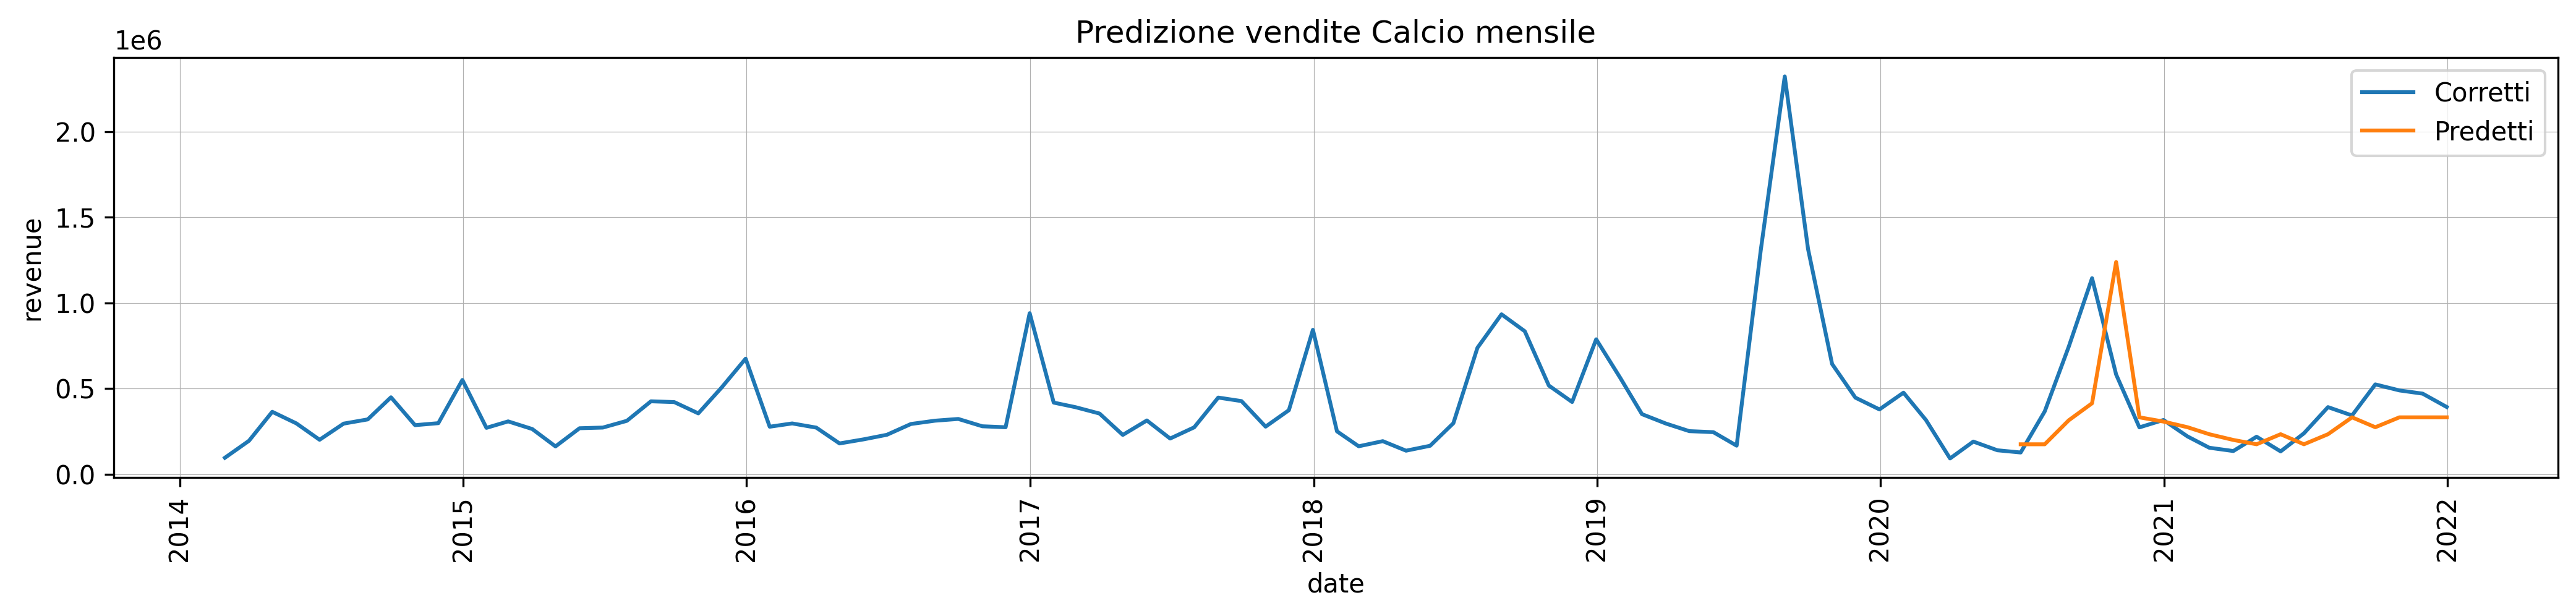

In [21]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_calcio, x= "year", y='revenue', label= "Corretti" )     #_evalutation
sns.lineplot(data=calcio_evalutation_ds, x='year', y='predictions', palette= "red",  label= "Predetti")

#x = calcio_evalutation_ds['year']  
#y = calcio_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = calcio_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  calcio_evalutation_ds

plt.title("Predizione vendite Calcio mensile")
plt.xlabel ("date")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

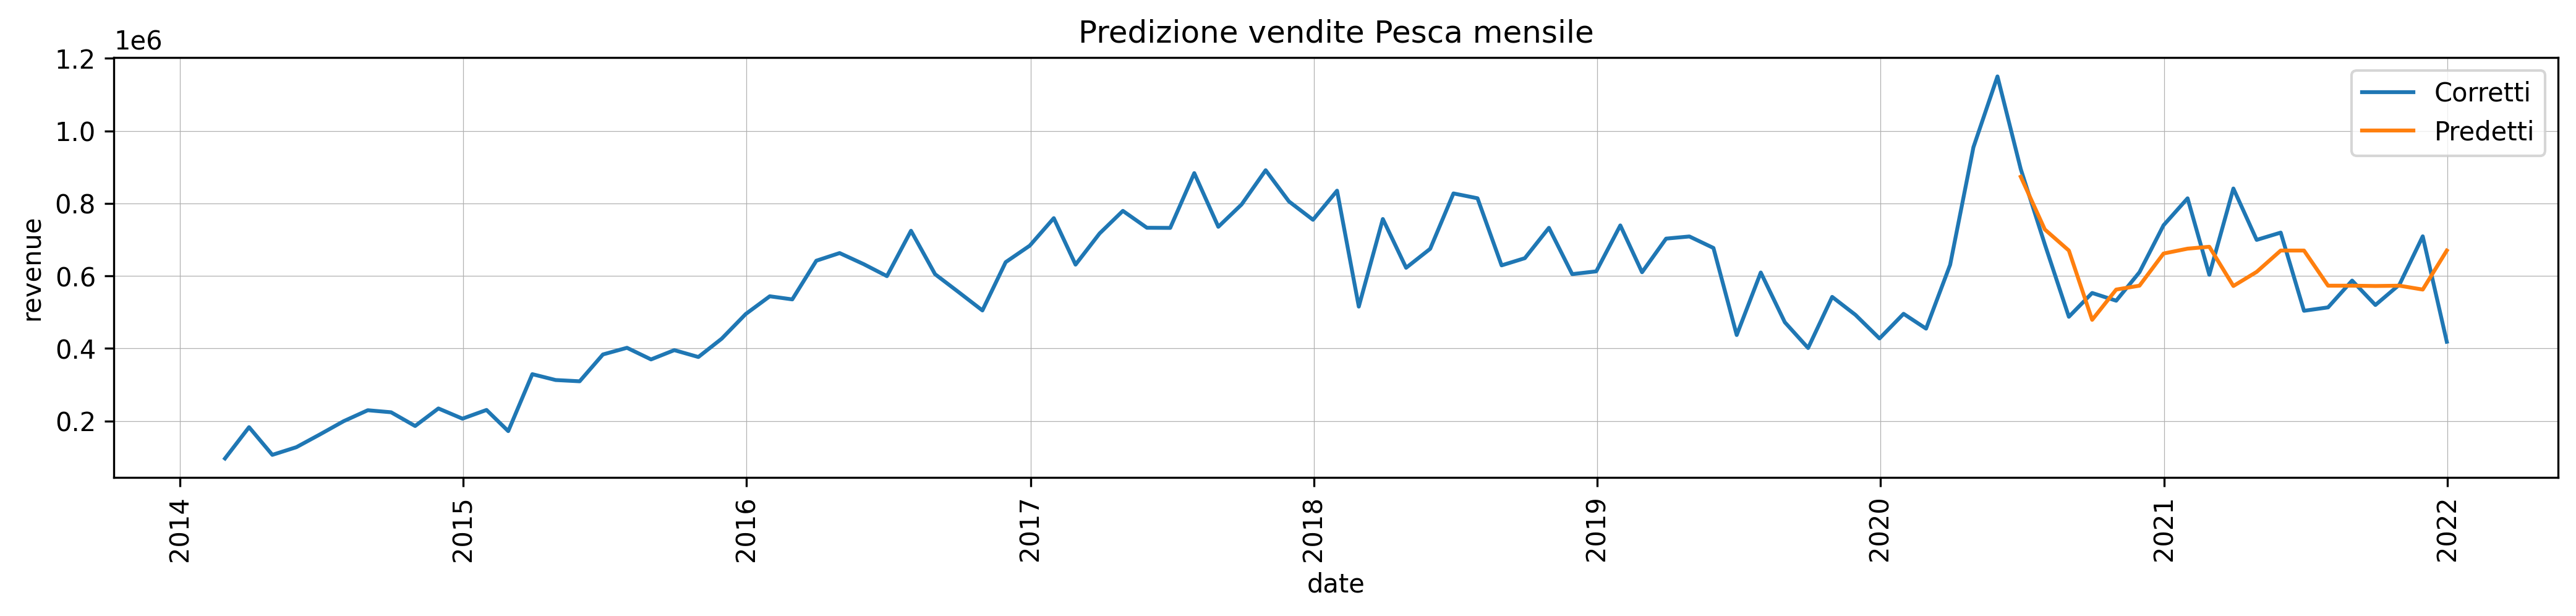

In [22]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_pesca, x= "year", y='revenue', label= "Corretti")     
sns.lineplot(data=pesca_evalutation_ds, x='year', y='predictions', palette= "red", label= "Predetti") 

#x = pesca_evalutation_ds['year']  
#y = pesca_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = pesca_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  pesca_evalutation_ds

plt.title("Predizione vendite Pesca mensile")
plt.xlabel ("date")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

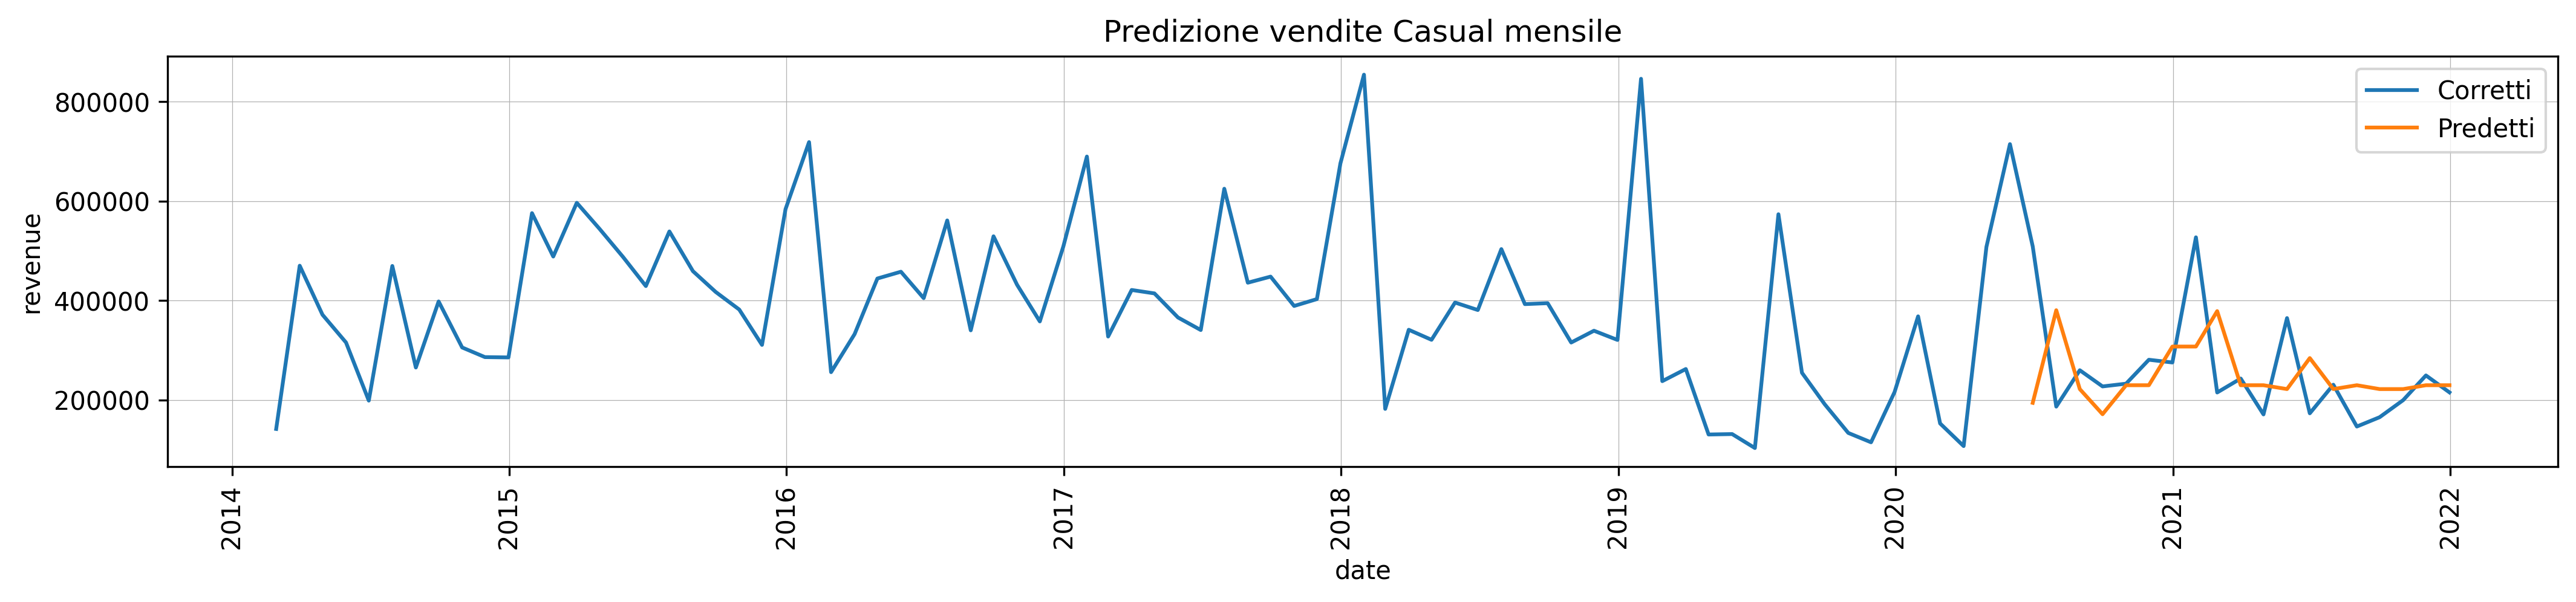

In [23]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_casual, x= "year", y='revenue', label= "Corretti")     
sns.lineplot(data=casual_evalutation_ds, x='year', y='predictions', palette= "red", label= "Predetti") 

#x = casual_evalutation_ds['year']  
#y = casual_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = casual_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  casual_evalutation_ds

plt.title("Predizione vendite Casual mensile")
plt.xlabel ("date")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [24]:
calcio_evalutation_ds

,year,revenue,totale_periodo_prec,predictions
0,2020-06-30,126425.81,139353.94,1.743312e+05
1,2020-07-31,366231.25,126425.81,1.743312e+05
2,2020-08-31,744662.00,366231.25,3.144873e+05
3,2020-09-30,1143860.62,744662.00,4.137577e+05
4,2020-10-31,581780.80,1143860.62,1.238258e+06
5,2020-11-30,273004.54,581780.80,3.316428e+05
6,2020-12-31,316115.35,273004.54,3.069455e+05
7,2021-01-31,220170.52,316115.35,2.738790e+05
8,2021-02-28,154246.91,220170.52,2.331040e+05
9,2021-03-31,134986.46,154246.91,1.996833e+05


In [25]:
pesca_evalutation_ds

,year,revenue,totale_periodo_prec,predictions
0,2020-06-30,894853.57,1150386.50,873690.2500
1,2020-07-31,687405.89,894853.57,728292.8750
2,2020-08-31,487386.30,687405.89,670114.0625
3,2020-09-30,553079.33,487386.30,478930.9375
4,2020-10-31,531739.65,553079.33,562488.1875
5,2020-11-30,610337.83,531739.65,573182.8125
6,2020-12-31,739810.32,610337.83,661847.1250
7,2021-01-31,814191.95,739810.32,675275.3750
8,2021-02-28,603193.05,814191.95,680568.8125
9,2021-03-31,841232.01,603193.05,572283.5000


In [26]:
casual_evalutation_ds

,year,totale_periodo_prec,revenue,predictions
0,2020-06-30,714875.51,509121.69,194331.484375
1,2020-07-31,509121.69,186785.32,380690.562500
2,2020-08-31,186785.32,259979.55,222033.468750
3,2020-09-30,259979.55,227387.68,171457.859375
4,2020-10-31,227387.68,232932.72,229800.687500
5,2020-11-30,232932.72,281042.27,229800.687500
6,2020-12-31,281042.27,275545.76,307610.093750
7,2021-01-31,275545.76,527328.22,307610.093750
8,2021-02-28,527328.22,215185.48,378878.125000
9,2021-03-31,215185.48,243257.05,229800.687500


In [27]:
print('Calcio XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(calcio_evalutation_ds["revenue"] - calcio_evalutation_ds["predictions"])))

Calcio XgBoost Mean Absolute Error (MAE):  173958.353125


In [28]:
print('Pesca XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(pesca_evalutation_ds["revenue"] - pesca_evalutation_ds["predictions"])))

Pesca XgBoost Mean Absolute Error (MAE):  93778.02644736841


In [29]:
print('Casual XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(casual_evalutation_ds["revenue"] - casual_evalutation_ds["predictions"])))

Casual XgBoost Mean Absolute Error (MAE):  84388.26513157896


In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
print('Calcio XgBoost Mean Absolute Percentage Error (MAPE): ', mean_absolute_percentage_error(calcio_evalutation_ds["revenue"], calcio_evalutation_ds["predictions"]))

Calcio XgBoost Mean Absolute Percentage Error (MAPE):  40.18727307048325


In [32]:
print('Pesca XgBoost Mean Absolute Percentage Error (MAPE): ', mean_absolute_percentage_error(pesca_evalutation_ds["revenue"], pesca_evalutation_ds["predictions"]))

Pesca XgBoost Mean Absolute Percentage Error (MAPE):  15.865010015386149


In [33]:
print('Casual XgBoost Mean Absolute Percentage Error (MAPE): ', mean_absolute_percentage_error(casual_evalutation_ds["revenue"], casual_evalutation_ds["predictions"]))

Casual XgBoost Mean Absolute Percentage Error (MAPE):  32.48807779118792


(Calcio migliore intorno ai 160)
(Pesca migliore intorno ai 300)
(Casual migliore intorno ai 160)




Con shift +1 mese


* Calcio XgBoost Mean Absolute Error (MAE):  173958.35
* Pesca XgBoost Mean Absolute Error (MAE):  93778.03
* Casual XgBoost Mean Absolute Error (MAE):  84388.27


* Calcio XgBoost Mean Absolute Percentage Error (MAPE):  40.19 %
* Pesca XgBoost Mean Absolute Percentage Error (MAPE):  15.87 % 
* Casual XgBoost Mean Absolute Percentage Error (MAPE):  32.49 %




Con shift +12 mesi


* Calcio XgBoost Mean Absolute Error (MAE):  159217.07
* Pesca XgBoost Mean Absolute Error (MAE):  137792.25
* Casual XgBoost Mean Absolute Error (MAE):  112219.62


* Calcio XgBoost Mean Absolute Percentage Error (MAPE):  48.12 %
* Pesca XgBoost Mean Absolute Percentage Error (MAPE):  22.39 %
* Casual XgBoost Mean Absolute Percentage Error (MAPE):  49.20 %